# Выявление профилей пользователей

# Описание проекта

Интернет-магазина товаров для дома и быта «Пока все ещё тут» хочет рассылать персонализированные предложения своим клиентам.
Необходимо проанализировать данные о покупках клиентов интернет-магазина, сегментировать покупателей по совершенным покупкам и выдать рекомендации бизнесу.

Для этого нам доступен датасет с транзакциями интернет-магазина с 1 октября 2018 по 31 января 2020 года. 

# Описание данных

Файл `ecom_dataset_upd.csv`:

- date — дата заказа;
- customer_id — идентификатор покупателя;
- order_id — идентификатор заказа;
- product — наименование товара;
- quantity — количество товара в заказе;
- price — цена товара.

# Ход выполнения проекта

**Шаг 1. Загрузить данные и изучить общую информацию**

**Шаг 2. Предобработка данных**
- найти и изучить пропущенные значения в столбцах
- проверить датафрейм на наличие дубликатов и обработать их
- проверить корректность типов данных
- добавить столбцы с месяцем и годом

**Шаг 3.  Исследовательский анализ**
- период исследования (минимальная и максимальная даты)
- количество клиентов в датасете
- выручка
- количество заказов совершаемое одним пользователем (частота)
- количество товаров на 1 покупку 
- средний чек

**Шаг 4. Сегментация покупателей и выделение категорий товаров**
- выделение категорий согласно наименованию товара
- сегментация покупателей (RFM-анализ)
- объединение таблиц
- выявить сезонность сегментов (изменения по частоте, сумме и количеству покупок по месяцам)

**Шаг 5. Проверка гипотез**
- Есть ли стат.значимая разница между выручкой разных сегментов?
    - Н0: Между сегментами нет стат.значимая разница в выручке
    - Н1: Между сегментами есть стат.значимая разница в выручке
- Есть ли стат.значимая разница между давностью покупок разных сегментов?
    - Н0: Между сегментами нет стат.значимой разницы в давности покупок
    - Н1: Между сегментами есть стат.значимая разница в давности покупок

**Шаг 6. Презентация**

**Шаг 7. Общий вывод, рекомендации**

### Загрузить данные и изучить общую информацию

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
import datetime as dt
from time import strptime
import math 
from plotly import graph_objects as go
import plotly.express as px

In [2]:
# импортируем кроссплатформенную библиотеку для создания статических изображений 
! pip install -U kaleido

In [3]:
# загрузим данные 
data = pd.read_csv('/datasets/ecom_dataset_upd.csv')

In [4]:
# выведем общую информацию
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


In [5]:
# выведем первые 5 строк датафрейма
data.head(5)

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


В датафрейме 6 столбцов и 7474 строк, содержащих информацию о дате заказа, идентификатор покупателя, идентификатор заказа, наименование и количестве купленного товара, а также цене этого товара.\
Судя по всему нет пропусков.\
Необходимо привести столбец `date` к необходимому типу данных (datetime).

### Предобработка данных

#### Найти и изучить пропущенные значения в столбцах

In [6]:
# проверим наличие пропусков
data.isna().sum()

date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
dtype: int64

Пропусков нет.

#### Проверить датафрейм на наличие дубликатов и обработать их

In [7]:
# проверим наличие дубликатов
data.duplicated().sum()

0

Явных дубликатов не выявлено.\
Попробуем поискать неявные.

In [8]:
# приведем столбец product к нижнему регистру
data['product'] = data['product'].str.lower()

# заменим буквы ё в названиях покупок на е
data['product'] = data['product'].str.replace('ё', 'е')

In [9]:
# проверим наличие дубликатов
data.duplicated().sum()

0

Дубликаты не найдены.\
Посмотрим на данные без учета даты.

In [10]:
# проверим дубликаты без учёта даты
data.duplicated(subset = ['customer_id', 'order_id', 'product', 'quantity', 'price']).sum()

1864

In [11]:
# количество дубликатов в процентном соотношении
print('Процент дубликатов:', round(data.duplicated(subset = ['customer_id', 'order_id', 'product', 'quantity', 'price']).sum()/len(data)* 100, 2))

Процент дубликатов: 24.94


В датафрейме найдено 1864 полных дубликата без учёта даты заказа - это 25% записей от общего количества (что очень много), то есть одни и те же заказы были привязаны к разным датам. Удалим дубликаты и оставим только впервые зафиксированный подобный заказ.

In [12]:
# удалим дубликаты оставив только первую зафиксированную запись из выявленных дубликатов
data.drop_duplicates(subset = ['customer_id', 'order_id', 'product', 'quantity', 'price'], keep = 'first', inplace = True)

In [13]:
# проверим изменения
data.duplicated(subset = ['customer_id', 'order_id', 'product', 'quantity', 'price']).sum()

0

Все выявленные дубликаты удалены.

In [14]:
# размер датафрейма
data.shape

(5610, 6)

Проверим датафрейм на наличие заказов совершенных более чем одним покупателем.

In [15]:
# сгруппируем данные по номеру заказа и уникальным пользователем сделавшим их
order_by_customer = data.groupby('order_id').agg({'customer_id': 'nunique'}).reset_index()

# сделаем срез по заказам принадлежавших более 1 клиентам 
two_orders = order_by_customer.query('customer_id > 1').reset_index(drop=True)

# выведем количество таких заказов
len(two_orders)

29

Оказалось 29 заказов принадлежавших разным пользователям, такого быть не должно, удалим эти заказы.

In [16]:
# оставим только номер заказа
two_orders = two_orders['order_id']

In [17]:
# удалим заказы совершенных более чем одним покупателем
data = data.query('order_id not in @two_orders')

In [18]:
# выведем размер датафрейма
display(data.shape)

(5544, 6)

Заказы, совершенные более чем одним покупателем, удалены.

#### Проверить корректность типов данных

In [19]:
# приведем столбцец date к нужному формату 
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d%H')

In [20]:
# проверим изменения
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5544 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         5544 non-null   datetime64[ns]
 1   customer_id  5544 non-null   object        
 2   order_id     5544 non-null   int64         
 3   product      5544 non-null   object        
 4   quantity     5544 non-null   int64         
 5   price        5544 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 303.2+ KB


#### Добавление столбцов года и месяца

In [21]:
# добавим столбец с номером месяца
data['month'] = data['date'].astype('datetime64[M]')

In [22]:
# добавим столбец с годом
data['year'] = data['date'].dt.year

In [23]:
# выведем общую информацию
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5544 entries, 0 to 7473
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         5544 non-null   datetime64[ns]
 1   customer_id  5544 non-null   object        
 2   order_id     5544 non-null   int64         
 3   product      5544 non-null   object        
 4   quantity     5544 non-null   int64         
 5   price        5544 non-null   float64       
 6   month        5544 non-null   datetime64[ns]
 7   year         5544 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(3), object(2)
memory usage: 389.8+ KB


В результате предобработки данных удалили 1864 дубликата, привели столбец `date` к формату `datetime64` и добавили 2 столбца - с месяцем и годом совершения покупки.

In [24]:
data.head(5)

,date,customer_id,order_id,product,quantity,price,month,year
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,2018-10-01,2018
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,2018-10-01,2018
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,2018-10-01,2018
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,2018-10-01,2018
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,2018-10-01,2018


### Исследовательский анализ

#### Период исследования (минимальная и максимальная даты)

In [25]:
# найдём манимальную дату представленную в датафрейме
data['date'].min()

Timestamp('2018-10-01 00:00:00')

In [26]:
# найдём максимальную дату представленную в датафрейме
data['date'].max()

Timestamp('2020-01-31 15:00:00')

Период исследования с 1.10.2018 года (минимальная дата представленная в датафрейме) по 31.01.2020 года (максимальная дата).

#### Количество клиентов в датасете

In [27]:
data['customer_id'].nunique()

2413

В таблице представлено 2413 уникальных клиентов.

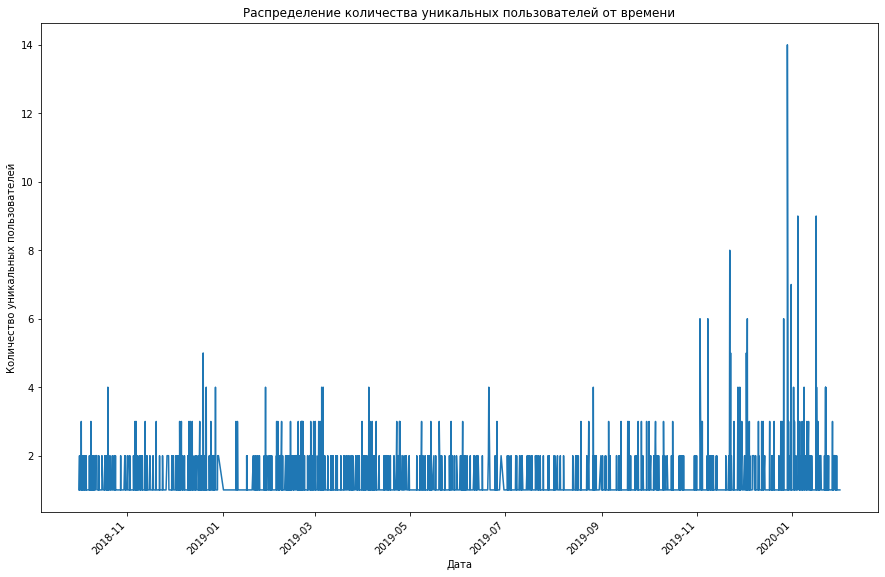

In [28]:
# распределение количества уникальных пользователей со временем
data.groupby('date')['customer_id'].nunique().plot(figsize=(15,10))
plt.title('Распределение количества уникальных пользователей от времени')
plt.ylabel('Количество уникальных пользователей')
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.show()

Резкий рост в количестве новых покупателей наблюдается в конце декабря 2019 - начале 2020 года, в остальном количество уникальных пользователей распределено равномерно с течением времени.

#### Выручка

In [29]:
# добавим столбец с общей суммой покупки
data['total'] = data['quantity'] * data['price']

# посчитаем общую выручку магазина и округлим выручку до 1 цифры после запятой
revenue = data['total'].sum().round(1)

# выведем выручку на экран
print('Общая выручка интеренет магазина :', revenue, 'руб.')

Общая выручка интеренет магазина : 4601279.4 руб.


Общая выручка интернет-магазина с 1 октября 2018 по 31 января 2022 года составила 4 601 279.4 руб.

In [30]:
# отсортируем стоимость заказов по убыванию и выведем первые строки таблицы
data[['customer_id', 'total']].sort_values(by='total', ascending=False)

,customer_id,total
5456,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,675000.0
5071,146cd9bf-a95c-4afb-915b-5f6684b17444,49432.0
1518,58a4c3cc-504f-43ea-a74a-bae19e665552,47385.0
1299,6987e6d6-a63a-4ce2-a2d0-f424092d235e,32718.0
1023,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,29248.0
...,...,...
2169,0f47231c-3a68-404a-88f7-08a4a172c17f,10.0
1078,2c8b9386-2e8c-4ee9-8aa4-2b4875b68578,9.0
2159,0f47231c-3a68-404a-88f7-08a4a172c17f,9.0
7073,1f7a71e2-0e7a-47ee-89d8-320b6315f4c7,9.0


Первые позиции занимают аномально дорогие покупки.

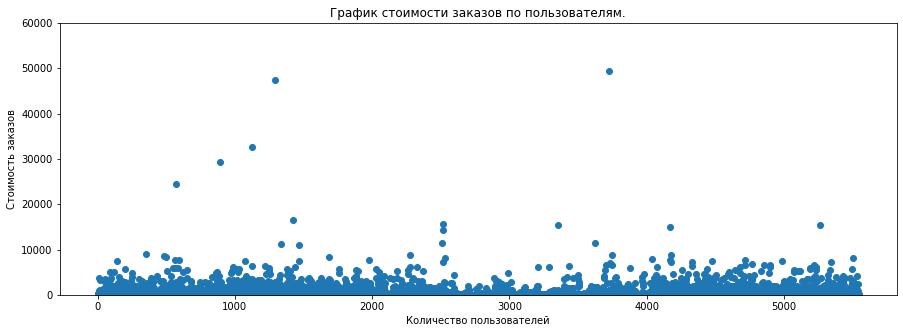

In [31]:
# серия чисел от 0 до указанного в data['total']
x_values = pd.Series(range(0,len(data['total'])))

# задаем размеры графика
plt.figure(figsize=(15,5))

# построим точечную диаграмму числа заказов на одного пользователя
plt.scatter(x_values, data['total']) 
plt.ylim(0,60000)
plt.title('График стоимости заказов по пользователям.')
plt.xlabel('Количество пользователей')
plt.ylabel('Стоимость заказов')
plt.show()

Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.

In [32]:
np.percentile(data['total'], [95, 99])

array([2850., 6149.])

Не более 5% заказов дороже 2 849 рублей и не более 1% дороже 6 108 рублей. Выберем 10000 рублей за верхнюю границу стоимости заказов и отсеим аномальных пользователей по ней.

In [33]:
# сделаем срез по клиентам сделавшим заказы свыше 10 тыс.руб
many_total = data.query('total > 10000').reset_index(drop=True)

# выведем количество таких клиентов
len(many_total)

16

13 заказов стоимость выше 10 тыс.руб

In [34]:
# оставим только номер заказа
many_total = many_total['order_id']
many_total

0      68878
1      69156
2      69504
3      69830
4      69928
5      70080
6      70135
7      71204
8      71205
9      71206
10     71478
11     71598
12     71668
13     71743
14     72139
15    107812
Name: order_id, dtype: int64

In [35]:
# удалим заказы стоимостью выше 10 тыс.руб
data = data.query('order_id not in @many_total')

#### Количество заказов совершаемое одним пользователем (частота)

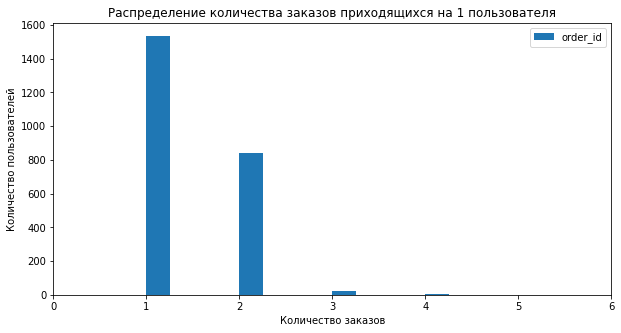

In [36]:
# построим визуализацию распределения количества заказов совершающих 1 пользователем
data.groupby('customer_id').agg({'order_id':'nunique'}).plot(kind='hist', bins = 500 , figsize=(10,5))
plt.title('Распределение количества заказов приходящихся на 1 пользователя')
plt.ylabel('Количество пользователей')
plt.xlabel('Количество заказов')
plt.xlim(0,6)
plt.show()

In [37]:
# количество заказов совершаемое одним пользователем
orders = data.groupby('customer_id').agg({'order_id':'nunique'}).reset_index()

# присвоим столбцам понятные названия
orders.columns = ['customer_id', 'orders']

# выведем на экран количества заказов на пользователя
display(orders['orders'].value_counts())

# отсортируем по количеству заказов и выведем первые строки таблицы
print(orders.sort_values(by='orders', ascending=False).head(10))

1      1534
2       842
3        20
4         2
126       1
5         1
7         1
17        1
35        1
Name: orders, dtype: int64

                               customer_id  orders
1875  c971fb21-d54c-4134-938f-16b62ee86d3b     126
726   4d93d3f6-8b24-403b-a74b-f5173e40d7db      35
1073  73d1cd35-5e5f-4629-8cf2-3fda829d4e58      17
1709  b7b865ab-0735-407f-8d0c-31f74d2806cc       7
17    0184f535-b60a-4914-a982-231e3f615206       5
1780  bea7a833-2074-42db-bc49-4457abd3c930       4
2100  e0535076-6270-4df2-8621-cb06264a94fa       4
2259  f163e581-59ba-4022-99db-e0973c7497c0       3
1938  d02429ab-22e0-4ff2-9465-3082befde444       3
985   6b0c6cfb-7717-4c34-8535-bbc6e2b2c758       3


Большинство клиентов (1554 человек) совершают в интернет-магазине заказ лишь единажды. Практически в 2 раза меньше клиентов, которые совершают 2 заказа (869 человек) и совсем небольшое количество пользователей с 3 (20 человек) и 4 заказами (3 человека). Однако есть пользователи с 35 и даже 126 заказами, скорее всего это аномалии. Посмотрим на это подробнее.

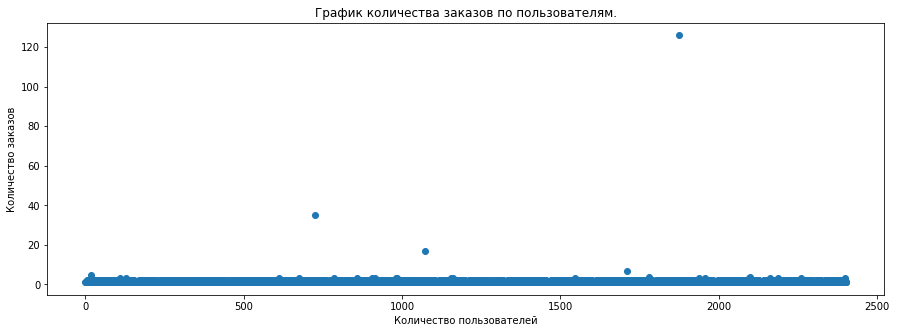

In [38]:
# серия чисел от 0 до указанного в orders
x_values = pd.Series(range(0,len(orders)))

# задаем размеры графика
plt.figure(figsize=(15,5))

# построим точечную диаграмму числа заказов на одного пользователя
plt.scatter(x_values, orders['orders']) 
plt.title('График количества заказов по пользователям.')
plt.xlabel('Количество пользователей')
plt.ylabel('Количество заказов')
plt.show()

Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.

In [39]:
# посчитаем 95-й и 99-й перцентили количества заказов на пользователя
np.percentile(orders['orders'], [95, 99])

array([2., 3.])

Не более 5% пользователей оформляли больше 2 заказов. И лишь 1% пользователей заказывали более 3 раз. 
Выберем 3 заказа на одного пользователя за верхнюю границу числа заказов и отсеим аномальных пользователей по ней.

In [40]:
# сделаем срез по клиентам сделавшим более 3 заказов
many_orders = orders.query('orders > 3').reset_index(drop=True)

# выведем количество таких клиентов
len(many_orders)

7

8 клиентов сделавших более 3 заказов, удалим их.

In [41]:
# оставим только номер айди клиента
many_orders = many_orders['customer_id']
many_orders

0    0184f535-b60a-4914-a982-231e3f615206
1    4d93d3f6-8b24-403b-a74b-f5173e40d7db
2    73d1cd35-5e5f-4629-8cf2-3fda829d4e58
3    b7b865ab-0735-407f-8d0c-31f74d2806cc
4    bea7a833-2074-42db-bc49-4457abd3c930
5    c971fb21-d54c-4134-938f-16b62ee86d3b
6    e0535076-6270-4df2-8621-cb06264a94fa
Name: customer_id, dtype: object

In [42]:
# удалим пользователей с более 3 заказами
data = data.query('customer_id not in @many_orders')

#### Количество товаров на 1 покупку

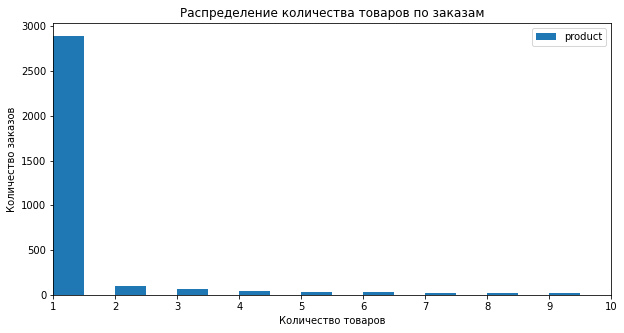

In [43]:
# построим визуализацию распределения количества товаров по заказам
data.groupby('order_id').agg({'product':'count'}).plot(kind='hist', bins = 100 , figsize=(10,5))
plt.title('Распределение количества товаров по заказам')
plt.ylabel('Количество заказов')
plt.xlabel('Количество товаров')
plt.xlim(1,10)
plt.show()

In [44]:
# количество покупок совершаемое одним пользователем
quantity = data.groupby('order_id').agg({'product':'count'}).reset_index()

# присвоим столбцам понятные названия
quantity.columns = ['order_id', 'quantity']

# выведем на экран количества заказов на пользователя
display(quantity['quantity'].value_counts())

# отсортируем по количеству покупок и выведем первые строки таблицы
print(quantity.sort_values(by='quantity', ascending=False).head(10))

1     2892
2      100
3       66
4       38
6       34
5       32
7       20
10      17
9       16
8       16
11      10
13       5
14       5
17       5
15       3
29       2
19       2
26       2
18       2
24       2
16       1
30       1
20       1
21       1
25       1
27       1
36       1
31       1
51       1
Name: quantity, dtype: int64

     order_id  quantity
127     14698        51
135     14715        36
119     14688        31
153     14753        30
131     14705        29
208     14835        29
203     14827        27
249     14897        26
220     14848        26
168     14778        25


Подавляющее большинство заказов - свыше 3 тыс. содержат лишь 1 товар, 2 товара содержат лишь 134 заказа, а 3 товара - 71 заказ, однако в некоторых товараха есть по 20, 30  и даже 51 заказу, скорее всего это аномалии. Посмотрим на это подробнее.

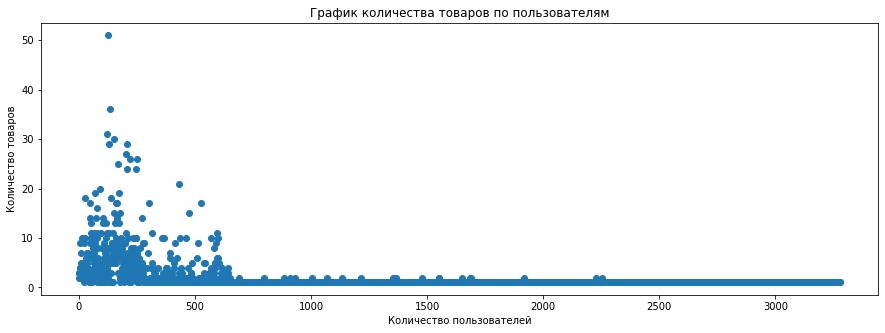

In [45]:
# серия чисел от 0 до указанного в orders
x_values = pd.Series(range(0,len(quantity)))

# задаем размеры графика
plt.figure(figsize=(15,5))

# построим точечную диаграмму числа заказов на одного пользователя
plt.scatter(x_values, quantity['quantity']) 
plt.title('График количества товаров по пользователям')
plt.xlabel('Количество пользователей')
plt.ylabel('Количество товаров')
plt.show()

Посчитаем 95-й и 99-й перцентили количества товаров на заказ. Выберем границу для определения аномальных заказов.

In [46]:
# посчитаем 95-й и 99-й перцентили количества заказов на пользователя
np.percentile(quantity['quantity'], [95, 99])

array([ 5., 13.])

Не более 5% пользователей оформляли покупали 5 товаров в одном заказе. И лишь 1% пользователей заказывали более 13 товаров. Выберем 13 товаров на один заказ за верхнюю границу числа товаров и отсеим аномальные заказы по ней.

In [47]:
# сделаем срез по заказам с более 13 товаров
many_quantity = quantity.query('quantity > 13').reset_index(drop=True)

# выведем количество таких заказов
len(many_quantity)

32

32 заказа с более 13 товаров в заказе.

In [48]:
# оставим только номер заказа
many_quantity = many_quantity['order_id']
many_quantity

0     14514
1     14548
2     14554
3     14596
4     14597
5     14608
6     14631
7     14663
8     14688
9     14698
10    14705
11    14715
12    14729
13    14750
14    14753
15    14764
16    14769
17    14770
18    14778
19    14784
20    14791
21    14827
22    14833
23    14835
24    14848
25    14893
26    14897
27    14932
28    68494
29    68760
30    68844
31    68941
Name: order_id, dtype: int64

In [49]:
# удалим заказы с более 13 товаров в заказе
data = data.query('order_id not in @many_quantity')

#### Средний чек

In [50]:
# посчитаем средний чек интернет-магазина
data.groupby('order_id')['total'].sum().mean().round()

1003.0

Средняя стоимость заказа в интернет-магазине составляет 1000 рублей.

### Сегментация покупателей и выделение категорий товаров

#### Выделение категорий согласно наименованию товара

In [51]:
# выведем список уникальных наименований продуктов
data['product'].unique().tolist()

['комнатное растение в горшке алое вера, d12, h30',
 'комнатное растение в горшке кофе арабика, d12, h25',
 'радермахера d-12 см h-20 см',
 'хризолидокарпус лутесценс d-9 см',
 'циперус зумула d-12 см h-25 см',
 'шеффлера лузеана d-9 см',
 'юкка нитчатая d-12 см h-25-35 см',
 'настенная сушилка для белья gimi brio super 100',
 'таз пластмассовый 21,0 л круглый "водолей" с614, 1404056',
 'вешалка для брюк металлическая с резиновым покрытием 26 см цвет: синяя, attribute, ahs331',
 'сушилка для белья потолочная zalger lift basic 1520 200 см, 10 м',
 'крючок одежный 2-х рожковый серый металлик с полимерным покрытием *тонар*, 1110027',
 'корзина мягкая пластиковая 17 л, м-пластика, m2880',
 'мини-сковорода marmiton "сердце" с антипригарным покрытием 12 см, lg17085',
 'сковорода алюминиевая с антипригарным покрытием marble alpenkok d = 26 см ak-0039a/26n',
 'стеклянная крышка для сковороды alpenkok 26 см ak-26gl',
 'сушилка для белья напольная colombo star 18, 3679',
 'доска гладильная eurog

In [52]:
# узнаем топ самых продаваемых товаров
top = data.groupby('product').agg({'quantity':'sum'}).reset_index()

# выведем топ-15 самых продаваемых товаров
top.sort_values(by='quantity', ascending = False).head(15)

,product,quantity
737,муляж яблоко 9 см красное,318
1268,"ручка-скоба рс-100 белая *трибатрон*, 1108035",201
591,"крепеж для пружины дверной, 1107055",170
983,плечики пластмассовые размер 52 - 54 тула 1205158,160
1056,пружина дверная 240 мм оцинкованная (д-19 мм) ...,150
739,муляж яблоко зеленый 9 см полиуретан,148
687,муляж банан желтый 21 см полиуретан,106
2015,"щетка для посуды *оля*, мультипласт 1807010",101
590,"крепеж для пружины дверной оцинкованный, 1107054",100
2014,щетка для мытья посуды колибри м5202 большая,100


В топ самых продаваемых товаров интернет-магазина оказались самые разнообразные товары, которые мы привыкли встречать в разных категориях (разделах) магазина, такие как, например : унитазный ерш в товарах для ванной комнаты ; щетки в хозяйственных товарах ; пружины, скобы и стяжки в разделе инструментов и т.д.

Для упрощения разбиения продуктов по категориям согласно наименованиям, попробуем выделить первое слово, как ключевое, и по ним составлять списки.

In [53]:
# добавим столбец с первым словом наименования продукта
data['product_first_word'] = data['product'].str.split(' ', expand=True)[0]

# выведем первые 5 строк
data.head(5)

,date,customer_id,order_id,product,quantity,price,month,year,total,product_first_word
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,2018-10-01,2018,142.0,комнатное
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,2018-10-01,2018,194.0,комнатное
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,2018-10-01,2018,112.0,радермахера
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,2018-10-01,2018,179.0,хризолидокарпус
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,2018-10-01,2018,112.0,циперус


In [54]:
# выведем все уникальные первые слова на экран
data['product_first_word'].unique().tolist()

['комнатное',
 'радермахера',
 'хризолидокарпус',
 'циперус',
 'шеффлера',
 'юкка',
 'настенная',
 'таз',
 'вешалка',
 'сушилка',
 'крючок',
 'корзина',
 'мини-сковорода',
 'сковорода',
 'стеклянная',
 'доска',
 'многолетнее',
 'рассада',
 'сумка',
 'тарелка',
 'ерш',
 'пеларгония',
 'котел',
 'суккулент',
 'эхеверия',
 'коврик',
 'подкладка',
 'набор',
 'дозатор',
 'нож',
 'эвкалипт',
 'муляж',
 'цветок',
 'сумка-тележка',
 'герань',
 'плед',
 'скатерть',
 'кувшин',
 'вилка',
 'ложка',
 'адиантум',
 'ковер',
 'перчатки',
 'стремянка',
 'гладильная',
 'лестница-стремянка',
 'толкушка',
 'искусственный',
 'банка',
 'комплект',
 'стяжка',
 'кампанула',
 'тележка',
 'противень',
 'калатея',
 'нолина',
 'плечики',
 'подушка',
 'полотенце',
 'хлорофитум',
 'цикламен',
 'крепеж',
 'пружина',
 'глоксиния',
 'азалия',
 'гортензия',
 'хризантема',
 'салфетка',
 'чехол',
 'вкладыши',
 'миксер',
 'кофр',
 'стиральный',
 'чистящий',
 'tepмокружка',
 'щетка',
 'мирт',
 'цветущее',
 'кориандр',
 'жи

Согласно первым ключевым словам классифицируем товары по категориям.

In [55]:
# комнатные растения и цветы 
plant = ['комнатное', 'спатифиллум','радермахера','хризолидокарпус лутесценс','циперус зумула', 'шеффлера лузеана',
         'юкка нитчатая', 'растение','герань','пеларгония','суккулент', 'эхеверия','эвкалипт','цветок','цветов',
         'адиантум', 'пеларгония','кампанула','калатея','нолина','хлорофитум','цикламен','глоксиния','азалия','гортензия',
         'хризантема','мирт','кориандр','иссоп','бальзамин','сантолина','аспарагус','афеляндра','антуриум','молодило',
         'фиалка','гербера','душица','мелисса','роза','фиалка','бегония','розмарин','антуриум','альбука','бальзамин',
         'бегония','крассула','артемизия','фиалка','лаванда','мята','каланхое','примула','салатник','дендробиум','калоцефалус',
         'каллуна','капсикум','крассула','мимоза','соланум','бархатцы','космея','петуния','алиссум','гвоздика','годеция',
         'календула','кореопсис','космея','лапчатка огненное пламя','львиный зев','флокс','цинерария','эшшольция','диффенбахия',
         'бальзамин','фаленопсис','подсолнечник','пуансетия','гиностемма','ель','кипарисовик','аптения','антуриум','пуансеттия',
         'крассула','скиммия','аспарагус','розмарин','фиттония','лаванда','тимьян','алоэ вера','аптения','спатифиллум шопен',
         'фикус','азалия','лиана','кодонанта','артемизия','томата','смолевка ','суккулент','эхеверия','нолина', 'хлорофитум',
         'цикламен','глоксиния','альбука','космея','мирт','цветущее','иссоп','сантолина','аспарагус','афеляндра','молодило',
         'бегония','каланхое','примула','дендробиум','калоцефалус','каллуна','капсикум','мимоза','соланум','годеция',
         'календула','кореопсис','лапчатка','флокс','цинерария','эшшольция','фаленопсис','подсолнечник', 'гиностемма',
         'кипарисовик', 'аптения','фикус','кодонанта','гимнокалициум', 'цикламен','эхинокактус','фал','крокусы','гипсофила',
         'калибрахоа','эпипремнум','аквилегия','незабудка','седум','нефролепис','калла','декабрист','тюльпан','гиацинт',
         'вербена','однолетнее','чабер','бакопа','ранункулус','газания','овсянница','георгина','смолевка','цинния','лавр',
         'вербейник','виола','колокольчик','котовник','эхинацея', 'ясколка','лилейник','папоротник','платикодон','энотера',
         'фуксия','цитрофортунелла','пеперомия','циния','синнингия','гардения','лобелия','табак','девичий','мускари',
         'пиретрум','агератум','колеус','тагетис','цинерания','муррайя','портулак','астра','аргирантерум','левкой','вероника',
         'целозия','маттиола','сальвия','джункус','драцена','фатсия','хоста','гайлардия','монарда', 'нивянник', 'рудбекия',
         'барвинок','осина','сциндапсус','пряные','бузульник','камнеломка','солидаго','физостегия','бадан','лен','антинакипин',
         'лантана', 'лаватера','анемона','буддлея','валериана','змееголовник','любисток','шалфей','вигна','хамедорея',
         'зверобой','мединилла','импатиенс','клен','замиокулькас','амариллис','салат','пахира','литопс','кофе','базилик',
         'шеффлера']

In [56]:
# товары для ванной
bathroom_goods = ['ерш','дозатор','комплект для ванной и туалета','подголовник','сиденье','пробка для ванны','вантуз',
                  'ванна','мыльница','таз','кувшин','ковш']

In [57]:
# хоз.товары
household_goods = ['щетка','сушилка','для гладильной доски','чехол','насадка','гладильная','набор прищепок','подкладка',
                   'контейнер','доска','измерительный','перчатки','гладиль','подрукавник','веник','швабра','лоток','ведро для мусора','корыто','урна','сметка','держатель','скребок',
                   'ролик','сменный блок для ролика','сменный','миска','рассекатель','сетка для глажения','сменная',
                   'комплект для мытья полов','фиксатор-шар', 'тряпкодержатель', 'сиденье для гладильной доски','ведро','совок',
                   'отжим','шпагат','прищепки','отделитель','веревка','мешок','запасная','универсальный','тряпка','мерный',
                   'основание','решетка','ящик почтовый','набор для пикника','автоматическая щетка leifheit для мытья окон с ручкой']

In [58]:
# бытовая химия
household_chemicals = ['порошок','крем','мыло','пена','паста','средство','бензин','антижир','бальзам','ополаскиватель',
                       'кондиционер для белья','защитная соль','гель','стиральный', 'чистящий','жидкое','зубная',
                       'ароматизированное','увлажняющая','концентрат']

In [59]:
# хранение и сумки
storage_things = ['вешалка','сумка-тележка','сумка','корзина','набор вешалок','крючок','тележка','плечики','вкладыши','кофр',
                  'ящик','короб','вешалки','комод','полк','коробка','этажерка','бак','подвесное','стеллаж','штанга','бидон',
                  'корзина мягкая','подставка для обуви','обувница','ложка обувная','корзинка','контейнер']

In [60]:
# товары для кухни
kitchen_goods = ['сковорода', 'крышка для сковороды', 'сотейник','кухонное','тарелка', 'лопатка','вилка', 'ложка', 'нож',
                 'набор кружек','набор фужеров','толкушка','чайник','банка','противень','контейнер для овощей','ножеточка',
                 'чайный набор','рыбочистка','терка','контейнер для приготовления','кружка','лопатка','стакан','чистка',
                 'набор бокалов','набор стаканов','кухонные ножницы','терка','губка','венчик','кисточка силиконовая для выпечки',
                 'скребок кондитерский','картофелемялка','набор форм для кексов','пресс для чеснока','защитный экран подставка',
                 'набор столовых приборов','термос','доска разделочная','бокал','блюдце','сито','контейнер для свч','бульонница',
                 'разделочная доска','емкость для соуса','подставка для ножей','просеиватель','кастрюля','хлебница',
                 'орехоколка','скалка','рукав','тортница','блюдо','сахарница','половник','емкость','форма','подставка для яйца',
                 'набор посуды']

In [61]:
# рассада
seedling = ['рассада','морковь','настурция','огурец засолочный','капуста','клубника','горох','земляника','томат',
            'укроп','дыня','арбуз','баклажан','клубника','патиссон','лук','петрушка','сельдерей','кабачок','тыква','огурец']

In [62]:
# декор интерьера и текстиль
interior_textiles = ['муляж','коврик','плед','скатерть','ковер','скатерть','штора','ковр','пододеяльник','подушка','полотенце',
                     'салфет','карниз','наматрасник','наматрицник','халат','полотенце','набор кухонных полотенец','покрывало',
                     'комплект постельного белья','одеяло','кольца для штор','фоторамка','ткань','бельевые','двуспальное',
                     'простынь','ключница картина','крючок','сервировочная','фоторамка','ключница','нетканые','ваза',
                     'простыня','комплект','энаматрацник','наволочка','складной','наматрацник']

In [63]:
# инструменты дял ремонта
tools_repair = ['стяжк','крепеж','пружина','петля','стремянк','сверел','сверло','сварка','шнур','угол','линейка',
                'шило','ручка','шпингалет','завертка','ручка','сверло','штангенциркуль','шприц','пьезозажигалка','набор']

In [64]:
# бытовая техника
appliances = ['котел','светильник','масленка','утюг', 'фен','мантоварка','термометр','весы','многофункциональный инструмент',
              'миксер','пароварка','кипятильник','соковарка','картофелемялка','пресс','термостакан','термос',
              'электроштопор','пылесос','окномойка','соковарка','соковыжималка','вакуумный','кипятильник','миксер',
              'tepмокружка','овощеварка','измельчитель овощей','термостакан','электроштопор']

Теперь напишем функцию, которая будет классифицировать товары по категориям выделенным выше.

In [65]:
# присвоим нулево значение для всех покупок
data['category'] = 0

# напишем функцию категоризации согласно списку выделенных категорий по наименованиям покупок
def category (list_name,category_name):
    join = '|'.join(list_name)
    word = data[data['product'].str.lower().str.contains(join)].index.to_list() 
    for i in word:
        data.loc[i,'category'] = category_name
        

In [66]:
# категоризируем по наименованию покупок
category(plant,'растения')
category(bathroom_goods,'товары для ванной')
category(household_goods,'хоз.товары')
category(household_chemicals,'бытовая химия')
category(storage_things,'хранение и сумки')
category(kitchen_goods,'товары для кухни')
category(seedling,'рассада')
category(interior_textiles,'декор интерьера и текстиль')
category(tools_repair,'инструменты для ремонта')
category(appliances,'бытовая техника')

#выведем первые 5 строк
data.head(5)

,date,customer_id,order_id,product,quantity,price,month,year,total,product_first_word,category
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,2018-10-01,2018,142.0,комнатное,растения
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,2018-10-01,2018,194.0,комнатное,растения
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,2018-10-01,2018,112.0,радермахера,растения
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,2018-10-01,2018,179.0,хризолидокарпус,растения
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,2018-10-01,2018,112.0,циперус,растения


In [67]:
# проверим остались ли товары без категории
data.query('category==0').count()

date                  0
customer_id           0
order_id              0
product               0
quantity              0
price                 0
month                 0
year                  0
total                 0
product_first_word    0
category              0
dtype: int64

Товаров без категории не найдено. Все товары разделены на категории согласно наименованию покупок.

In [68]:
# удалим столбец с первым словом по покупкам из датафрейма
data = data.drop(columns = ['product_first_word'])

In [69]:
# посмотрим на разбиения по категориям
data['category'].value_counts()

растения                      1586
хоз.товары                     619
хранение и сумки               603
рассада                        563
декор интерьера и текстиль     467
товары для кухни               270
инструменты для ремонта        209
товары для ванной              110
бытовая техника                 83
бытовая химия                   53
Name: category, dtype: int64

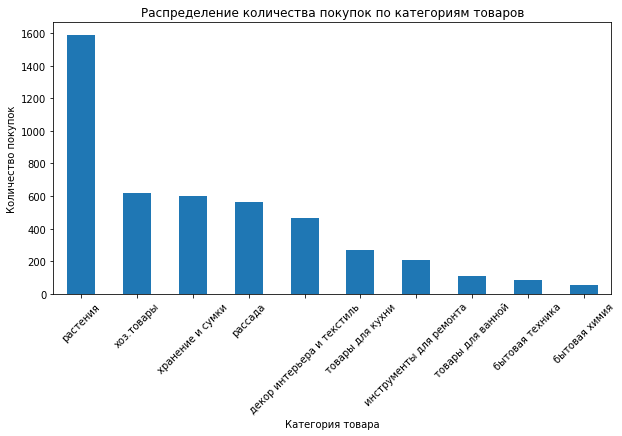

In [70]:
# визуализируем распределение числа покупок по товарным категориям
plt.figure(figsize=(10, 5))
data['category'].value_counts().plot(kind = 'bar')
plt.title('Распределение количества покупок по категориям товаров')
plt.ylabel('Количество покупок')
plt.xlabel('Категория товара')
plt.xticks(rotation=45)
plt.show()

Чаще всего клиенты интернет-магазина покупали товары из категории растения - 1586 покупок, меньше всего бытовой химии - 53.

В результате проведенного исследования разнесли товар по категориям.

#### RFM-анализ

Для сегментации покупателей применим RFM-анализ, который группирует покупателей на основе их покупок по таким критериям как:
- Recency - давность совершения покупки(сколько дней прошло с момента последней покупки)
- Frequency - частота покупок (сколько раз клиент совершал покупку в данном интернет-магазине)
- Monetary Value - денежную ценность (сколько денег принёс клиент бизнесу)

In [71]:
# извлечем необходимые значения (столбцы) из датасета для построения таблицы данных для RFM таблицы
temp = ['customer_id', 'order_id', 'date', 'total']

# данные для RFM таблицы
RFM_data = data[temp]

# размер данных
RFM_data.shape

(4563, 4)

В датасете 4563 строк и 4 столбца. Всё верно.

- Создание таблицы RFM


В датасете последний заказ был сделан 31 января 2020 года, для расчета давности используем дату последнего заказа +1 день для функции NOW.

In [72]:
# дата последнего заказа
NOW = RFM_data['date'].max() + timedelta(days=1)

# зададим RFM таблицу
RFM_table=RFM_data.groupby('customer_id').agg({'date': lambda x: (NOW - x.max()).days, # Recency
                                                'order_id': lambda x: len(x.unique()), # Frequency
                                                'total': lambda x: x.sum()})    # Monetary 
# зададим целочисленный тип данных
RFM_table['date'] = RFM_table['date'].astype(int)

# переименуем столбцы 
RFM_table.rename(columns={'date': 'recency', 
                         'order_id': 'frequency',
                          'total': 'monetary_value'}, inplace=True)

# выведем первые 5 строк
RFM_table.head(5)

,recency,frequency,monetary_value
customer_id,,,
000d6849-084e-4d9f-ac03-37174eaf60c4,108,1,555.0
001cee7f-0b29-4716-b202-0042213ab038,350,1,442.0
00299f34-5385-4d13-9aea-c80b81658e1b,109,1,914.0
002d4d3a-4a59-406b-86ec-c3314357e498,369,1,1649.0
003bbd39-0000-41ff-b7f9-2ddaec152037,124,1,2324.0


В результате построения таблицы получили значения критериев для каждого клиента на основе их покупок, характеризующих:
- `recency` - количество дней с момента последней покупки
- `frequency` - общее количество покупок/заказов
- `monetary_value` - сумма потраченных денег

- Далее рассчитаем показатель RFM. Для этого используем квинтили — составление четырех равных частей на основе доступных значений.

In [73]:
# зададим квантили
quantiles = RFM_table.quantile(q=[0.25,0.5,0.75])

# выведем на экран
quantiles

,recency,frequency,monetary_value
0.25,72.0,1.0,383.0
0.50,204.0,1.0,824.0
0.75,344.0,2.0,1756.5


Критерии разделены на 4 группы согласно их значениям.

In [74]:
# преобразуем квантили в словарь
quantiles = quantiles.to_dict()

# зададим таблицу для построение RFM сегментации
RFM_segment = RFM_table.copy()

# напишем функцию для оценки давности покупки
def R_class(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
    
# напишем функцию для оценки частоты и денежной ценности 
def FM_class(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
# применим функцию и добавим столбцы согласно оценке каждого критерия
RFM_segment['R_score'] = RFM_segment['recency'].apply(R_class, args=('recency',quantiles,))
RFM_segment['F_score'] = RFM_segment['frequency'].apply(FM_class, args=('frequency',quantiles,))
RFM_segment['M_score'] = RFM_segment['monetary_value'].apply(FM_class, args=('monetary_value',quantiles,))
RFM_segment['RFM_score'] = RFM_segment.R_score.map(str) \
                            + RFM_segment.F_score.map(str) \
                            + RFM_segment.M_score.map(str)

In [75]:
# приведем значение RFM к целочисленному значению
RFM_segment['RFM_score'] = RFM_segment['RFM_score'].astype(int)

In [76]:
# выведем первые 5 строк таблицы сегментации на экран
RFM_segment.head(5)

,recency,frequency,monetary_value,R_score,F_score,M_score,RFM_score
customer_id,,,,,,,
000d6849-084e-4d9f-ac03-37174eaf60c4,108,1,555.0,3,1,2,312
001cee7f-0b29-4716-b202-0042213ab038,350,1,442.0,1,1,2,112
00299f34-5385-4d13-9aea-c80b81658e1b,109,1,914.0,3,1,3,313
002d4d3a-4a59-406b-86ec-c3314357e498,369,1,1649.0,1,1,3,113
003bbd39-0000-41ff-b7f9-2ddaec152037,124,1,2324.0,3,1,4,314


В результате применения RFM-анализа разделили клиентов на сегменты, согласно их покупкам.\
Для выставления оценок сегментам использовали 2 функции, так как для давности покупок, чем меньше дней прошло с момента последней покупки (меньше число) - тем лучше, а для частоты и суммы денег, наоборот, чем больше число.\
Лучшая оценка - 4\
Худшая - 1\
Теперь, согласно выставленных оценок, можно определить лучших клиентов для бизнеса - кто покупает много, часто и дорого, и худших - кто покупал давно, редко и на небольшую сумму. Тех, кто находится на грани оттока и кого ещё можно попытаться удержать, а также перспективных клиентов и т.д.

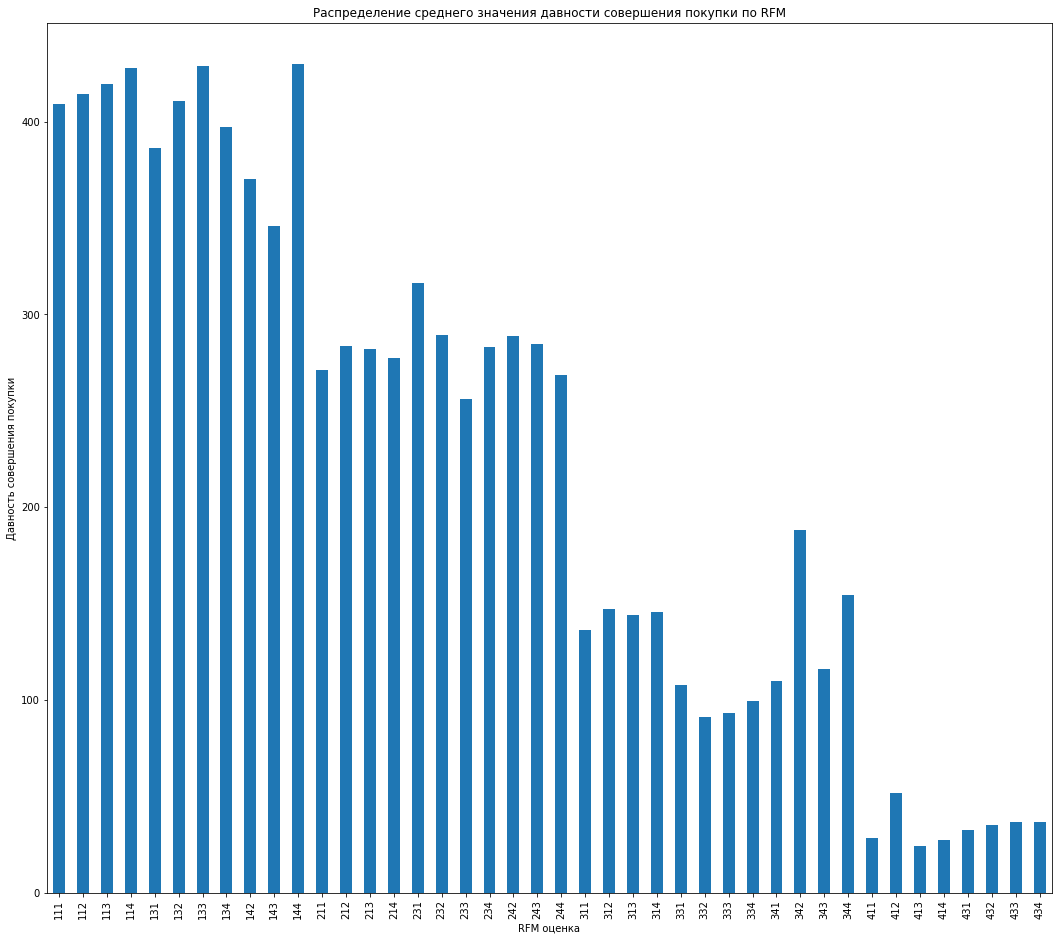

In [77]:
# визуализируем распределение среднего значения давности совершения покупки по RFM
plt.figure(figsize=(18, 16))
RFM_segment.groupby('RFM_score').agg('recency').mean().plot(kind='bar')
plt.title('Распределение среднего значения давности совершения покупки по RFM')
plt.ylabel('Давность совершения покупки')
plt.xlabel('RFM оценка')
plt.show()

Разделим всех клиентов интернет-магазина согласно оценки RFM:
- 111 - отток
- 112-144 - уходящие
- 211-244 - спящие
- 311-344 - перспективные
- 411-434 - лояльные

In [78]:
# напишем функцию для распределения клиентов на категории согласно оценки RFM
def categorize_segment(rfm):
    if rfm == 111:
        return 'отток'
    if rfm <= 144:
        return 'уходящие'
    if rfm <= 244:
        return 'спящие'
    if rfm <= 344:
        return 'перспективные'
    return 'лояльные'

In [79]:
# добавим столбец с названием сегмента в таблицу
RFM_segment['segment_name'] = RFM_segment['RFM_score'].apply(categorize_segment)

In [80]:
# выведем первые 5 строк таблицы сегментации на экран
RFM_segment.head(5)

,recency,frequency,monetary_value,R_score,F_score,M_score,RFM_score,segment_name
customer_id,,,,,,,,
000d6849-084e-4d9f-ac03-37174eaf60c4,108,1,555.0,3,1,2,312,перспективные
001cee7f-0b29-4716-b202-0042213ab038,350,1,442.0,1,1,2,112,уходящие
00299f34-5385-4d13-9aea-c80b81658e1b,109,1,914.0,3,1,3,313,перспективные
002d4d3a-4a59-406b-86ec-c3314357e498,369,1,1649.0,1,1,3,113,уходящие
003bbd39-0000-41ff-b7f9-2ddaec152037,124,1,2324.0,3,1,4,314,перспективные


В результате проведенного RFM-анализа разделили покупателей на 5 сегментов: отток, уходящие, спящие, перспективные и лояльные.

#### Объединение таблиц

In [81]:
# объединим таблицы с категориями покупок и сегментами 
merge = data.merge(RFM_segment, on='customer_id')

In [82]:
# выведем первые 5 строк
merge.head(5)

,date,customer_id,order_id,product,quantity,price,month,year,total,category,recency,frequency,monetary_value,R_score,F_score,M_score,RFM_score,segment_name
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,2018-10-01,2018,142.0,растения,488,1,1037.0,1,1,3,113,уходящие
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,2018-10-01,2018,194.0,растения,488,1,1037.0,1,1,3,113,уходящие
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,2018-10-01,2018,112.0,растения,488,1,1037.0,1,1,3,113,уходящие
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,2018-10-01,2018,179.0,растения,488,1,1037.0,1,1,3,113,уходящие
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,2018-10-01,2018,112.0,растения,488,1,1037.0,1,1,3,113,уходящие


In [83]:
# размер данных
merge.shape

(4563, 18)

Всё на месте.

In [84]:
# посчитаем количество клиентов в каждом из сегментов
RFM_segment['segment_name'].value_counts()

лояльные         598
спящие           592
перспективные    587
уходящие         442
отток            148
Name: segment_name, dtype: int64

#### Сезонность


##### лояльные клиенты

In [85]:
# выделим лояльных клиентов
loyal = merge.loc[merge['segment_name'] == 'лояльные']

In [86]:
# выведем первые строки на экран
loyal.head(5)

,date,customer_id,order_id,product,quantity,price,month,year,total,category,recency,frequency,monetary_value,R_score,F_score,M_score,RFM_score,segment_name
1003,2018-12-18 14:00:00,95815113-e6f7-43b5-b536-871f6194570c,69439,сумка-тележка хозяйственная gimi easy go синяя,1,1649.0,2018-12-01,2018,1649.0,хранение и сумки,72,2,3598.0,4,3,4,434,лояльные
1004,2019-11-20 18:00:00,95815113-e6f7-43b5-b536-871f6194570c,112077,"халат вафельный виктория_3-42 , 100% хлопок 26...",1,1949.0,2019-11-01,2019,1949.0,декор интерьера и текстиль,72,2,3598.0,4,3,4,434,лояльные
1006,2018-12-18 21:00:00,27a2e4a0-ca2d-49b3-b3bb-3d0e46d023b9,69446,"коврик в ванну 36х71 см, розовый",1,442.0,2018-12-01,2018,442.0,декор интерьера и текстиль,72,2,577.0,4,3,2,432,лояльные
1007,2019-11-20 23:00:00,27a2e4a0-ca2d-49b3-b3bb-3d0e46d023b9,108855,пуансеттия в горшке d12 см белая с красным,1,135.0,2019-11-01,2019,135.0,растения,72,2,577.0,4,3,2,432,лояльные
1008,2018-12-18 22:00:00,31e26121-aae6-4615-95d8-608f9a2de0f0,69447,стремянка-табурет алюминиевая hailo l90 step-k...,1,2699.0,2018-12-01,2018,2699.0,инструменты для ремонта,72,2,2759.0,4,3,4,434,лояльные


Для того, чтобы выявить сезонность сгруппируем данные лояльных клиентов по категориям товаров и месяцам покупок, посчитаем общую выручку, количество уникальных заказов, количество проданных товаров.

In [87]:
# сгруппируем таблицу
loyal_season = loyal.groupby(['month','category']).agg({'total':'sum','order_id':'nunique','product':'count'}).reset_index()

# переименуем столбцы для удобства
loyal_season.columns = ['month','category','revenue','order_amount','product_amount']

# добавим столбец со средней выручкой
loyal_season['average_bill'] = (loyal_season['revenue']/loyal_season['order_amount']).round()

# округлим значение выручки 
loyal_season['revenue'] = loyal_season['revenue'].round()

# выведем на экран
loyal_season.head(5)

,month,category,revenue,order_amount,product_amount,average_bill
0,2018-12-01,бытовая техника,375.0,1,1,375.0
1,2018-12-01,декор интерьера и текстиль,5096.0,6,6,849.0
2,2018-12-01,инструменты для ремонта,6409.0,4,4,1602.0
3,2018-12-01,растения,194.0,1,1,194.0
4,2018-12-01,товары для ванной,351.0,2,2,176.0


- выручка

Выведем сначала график выручки без учёта сезонности для того чтобы посмотреть как категории распределены между собой в целом.

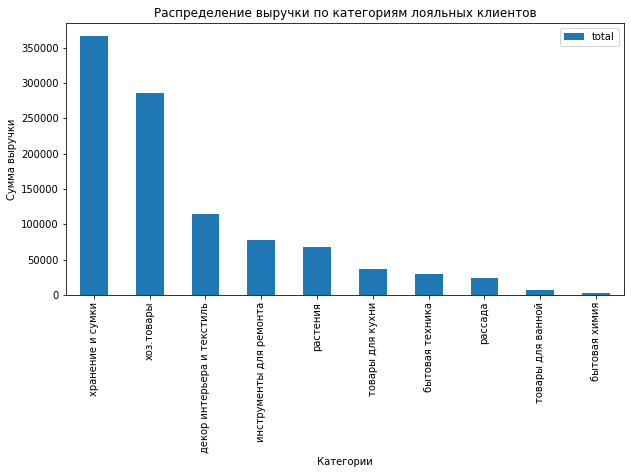

In [88]:
# визуализируем выручки по категориям лояльных клиентов
loyal.groupby('category').agg({'total':'sum'}).sort_values(by='total',ascending=False).plot(kind='bar',figsize=(10, 5))
plt.title('Распределение выручки по категориям лояльных клиентов')
plt.ylabel('Сумма выручки')
plt.xlabel('Категории')
plt.show()

Больше всего денег лояльные клиенты приносят из категорий хранения и сумок и хоз.товаров.

Посмотрим на сезонность.

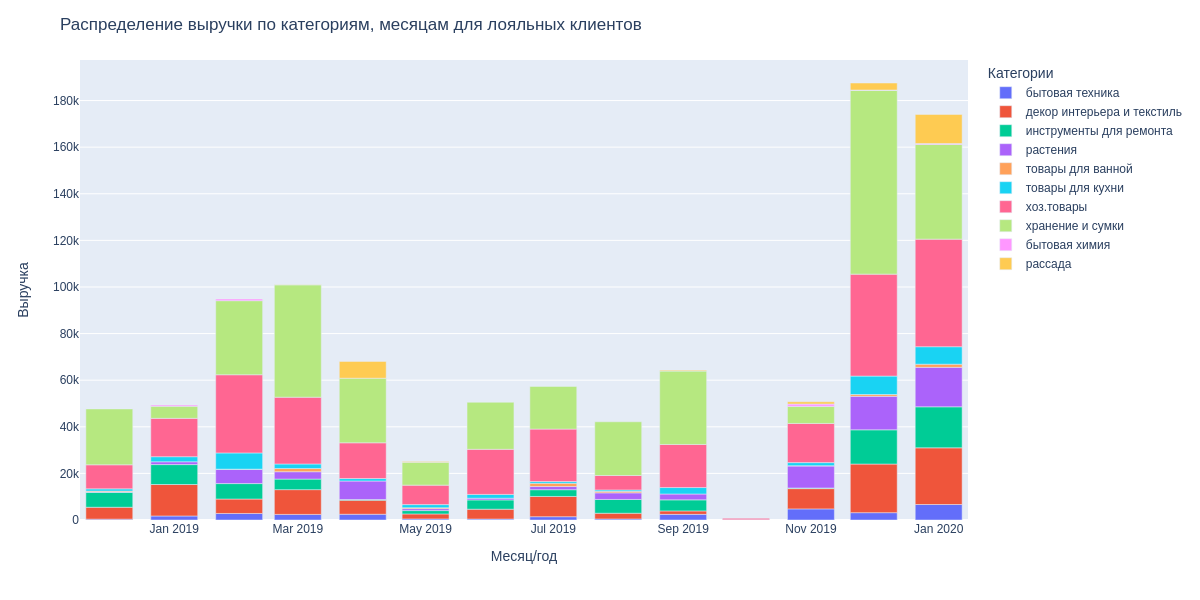

In [89]:
# распределение выручки по категориям, месяцам для лояльных клиентов
fig = px.bar(loyal_season, x="month", y="revenue", color = 'category')
fig.update_layout(title='Распределение выручки по категориям, месяцам для лояльных клиентов',
                   xaxis_title='Месяц/год',
                   yaxis_title='Выручка',
                   yaxis={'categoryorder':'total ascending'},
                  legend=dict(title="Категории"))
fig.show(renderer='png',width=1200, height=600)

В декабре явно увеличивается выручка товаров для хранения и сумки, также высокий спрос сохраняется в марте. Для декабря, февраля, марта характерно увеличение выручки на категорию хоз.товаров. Бытовой техникой хорошо закупаются в ноябре, а товарами для декора январе и декабре, также как и инструментами для ремонта. Повышения выручки от продажи растений - в ноябре, декабре ; товаров для кухни - в декабре и феврале, а расады в январе, апреле. Октябрь - низкий сезон.

##### перспективные клиенты

In [90]:
# выделим перспективных клиентов
promising = merge.loc[merge['segment_name'] == 'перспективные']

In [91]:
# выведем первые строки на экран
promising.head(5)

,date,customer_id,order_id,product,quantity,price,month,year,total,category,recency,frequency,monetary_value,R_score,F_score,M_score,RFM_score,segment_name
8,2018-10-01 08:00:00,6644e5b4-9934-4863-9778-aaa125207701,68478,"таз пластмассовый 21,0 л круглый ""водолей"" с61...",1,269.0,2018-10-01,2018,269.0,товары для ванной,92,2,307.0,3,3,1,331,перспективные
9,2019-10-31 16:00:00,6644e5b4-9934-4863-9778-aaa125207701,111409,"рассада дыни сорт казачка, горшок 9*9см",1,38.0,2019-10-01,2019,38.0,рассада,92,2,307.0,3,3,1,331,перспективные
11,2018-10-01 12:00:00,86432d8d-b706-463b-bd5d-6a9e170daee3,68484,сушилка для белья потолочная zalger lift basic...,1,614.0,2018-10-01,2018,614.0,хоз.товары,92,2,861.0,3,3,3,333,перспективные
12,2019-10-31 19:00:00,86432d8d-b706-463b-bd5d-6a9e170daee3,107076,"линейка, длина 30 см, truper, rgl-30/14387",1,247.0,2019-10-01,2019,247.0,инструменты для ремонта,92,2,861.0,3,3,3,333,перспективные
14,2018-10-01 16:00:00,a576fa59-7b28-4a4c-a496-92f128754a94,68487,"корзина мягкая пластиковая 17 л, м-пластика, m...",1,188.0,2018-10-01,2018,188.0,хранение и сумки,92,2,248.0,3,3,1,331,перспективные


Сгруппируем данные перспективных клиентов по категориям товаров и месяцам покупок, посчитаем общую выручку, количество уникальных заказов, количество проданных товаров.

In [92]:
# сгруппируем таблицу
promising_season = promising.groupby(['month', 'category']).agg({'total':'sum','order_id':'nunique','product':'count'}).reset_index()

# переименуем столбцы для удобства
promising_season.columns = ['month','category','revenue','order_amount','product_amount']

# добавим столбец со средней выручкой
promising_season['average_bill'] = (promising_season['revenue']/promising_season['order_amount']).round()

# округлим значение выручки 
promising_season['revenue'] = promising_season['revenue'].round()

# выведем на экран
promising_season.head(5)

,month,category,revenue,order_amount,product_amount,average_bill
0,2018-10-01,бытовая техника,1356.0,2,2,678.0
1,2018-10-01,декор интерьера и текстиль,6221.0,4,4,1555.0
2,2018-10-01,инструменты для ремонта,11508.0,5,5,2302.0
3,2018-10-01,растения,149.0,1,1,149.0
4,2018-10-01,товары для ванной,5310.0,8,8,664.0


- выручка

Выведем сначала график выручки без учёта сезонности для того чтобы посмотреть как категории распределены между собой в целом.

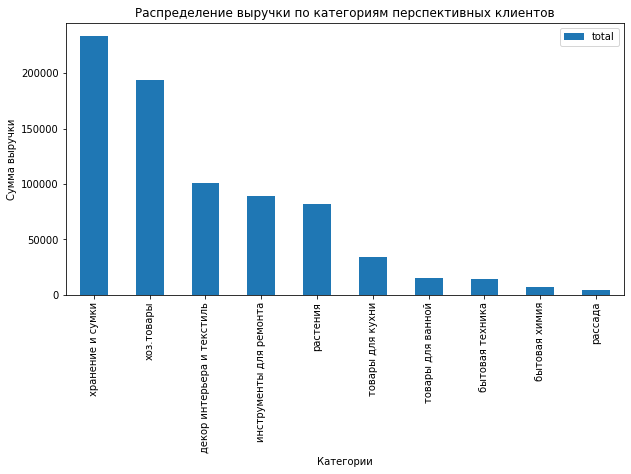

In [93]:
# визуализируем выручки по категориям перспективных клиентов
promising.groupby('category').agg({'total':'sum'}).sort_values(by='total',ascending=False).plot(kind='bar',figsize=(10, 5))
plt.title('Распределение выручки по категориям перспективных клиентов')
plt.ylabel('Сумма выручки')
plt.xlabel('Категории')
plt.show()

Больше всего денег перспективные клиенты принесли из категории хранения и сумок и хоз.товаров, а меньше всего по бытовой техники и химии, а также товаров для ванной и рассады.

Посмотрим на сезонность

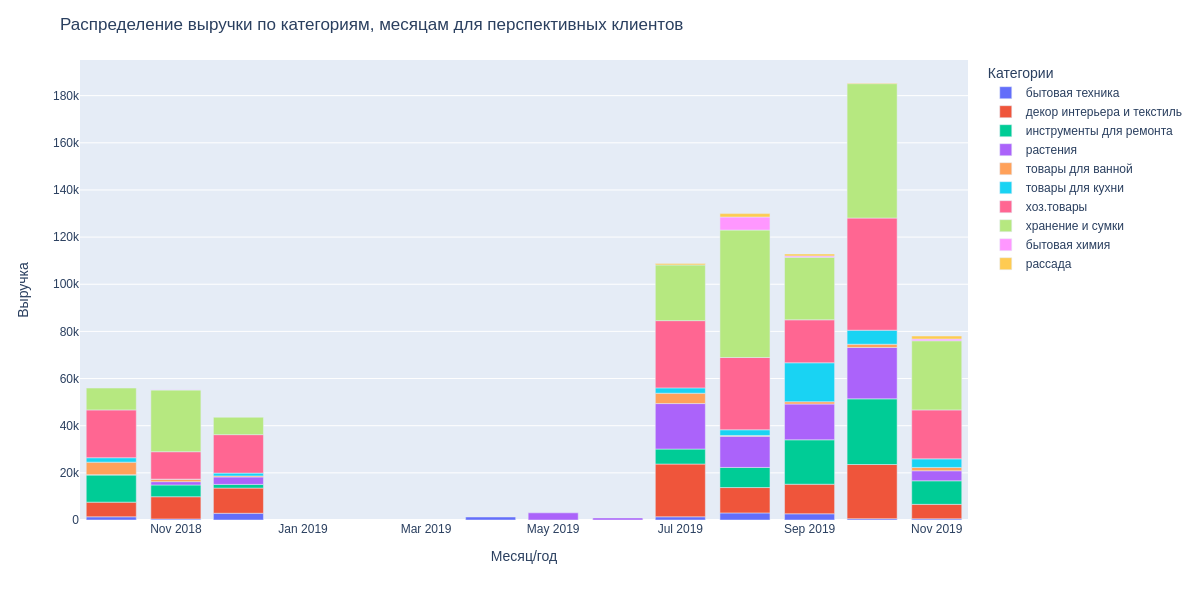

In [94]:
# распределение выручки по категориям и месяцам для перспективных клиентов
fig = px.bar(promising_season, x="month", y="revenue", color = 'category')
fig.update_layout(title='Распределение выручки по категориям, месяцам для перспективных клиентов',
                   xaxis_title='Месяц/год',
                   yaxis_title='Выручка',
                   yaxis={'categoryorder':'total ascending'},
                 legend=dict(title="Категории"))
fig.show(renderer='png',width=1200, height=600)

Клиенты данного сегмента практически не попали в покупки первой половины года, активные покупки демонстрируют с июля по ноябрь. Прослеживается увеличение выручки практически по всем категориям с августа по октябрь и уменьшение к декабрю. Наблюдается повышение выручки по категории хранения и сумок в августе и октябре, а также хоз.товаров в октябре. В категорих растения и товаров для интерьера и текстиля выручка растет в июле и октябре. Выручка с категории инструментов для ремонта увеличивается с июля достигая пика в октябре. Товары для ванны чуть лучше покупают в июле, а для кухни в сентябре. Для бытовой химии характерен рост в августе.

##### спящие клиенты

In [95]:
# выделим спящих клиентов
sleeping = merge.loc[merge['segment_name'] == 'спящие']

In [96]:
# выведем первые строки на экран
sleeping.head(5)

,date,customer_id,order_id,product,quantity,price,month,year,total,category,recency,frequency,monetary_value,R_score,F_score,M_score,RFM_score,segment_name
714,2018-11-21 21:00:00,8851c688-9846-4ec3-a3cc-6b07754c45bb,69081,герань домашняя (пеларгония зональная) цветуща...,1,149.0,2018-11-01,2018,149.0,растения,334,2,1088.0,2,3,3,233,спящие
715,2018-11-21 21:00:00,8851c688-9846-4ec3-a3cc-6b07754c45bb,69081,герань домашняя (пеларгония зональная) цветуща...,1,149.0,2018-11-01,2018,149.0,растения,334,2,1088.0,2,3,3,233,спящие
716,2018-11-21 21:00:00,8851c688-9846-4ec3-a3cc-6b07754c45bb,69081,герань домашняя (пеларгония зональная) цветуща...,1,149.0,2018-11-01,2018,149.0,растения,334,2,1088.0,2,3,3,233,спящие
717,2018-11-21 21:00:00,8851c688-9846-4ec3-a3cc-6b07754c45bb,69081,герань домашняя (пеларгония зональная) цветуща...,1,149.0,2018-11-01,2018,149.0,растения,334,2,1088.0,2,3,3,233,спящие
718,2018-11-21 21:00:00,8851c688-9846-4ec3-a3cc-6b07754c45bb,69081,герань домашняя (пеларгония зональная) цветуща...,1,149.0,2018-11-01,2018,149.0,растения,334,2,1088.0,2,3,3,233,спящие


Сгруппируем данные спящих клиентов по категориям товаров и месяцам покупок, посчитаем общую выручку, количество уникальных заказов, количество проданных товаров.

In [97]:
# сгруппируем таблицу
sleeping_season = sleeping.groupby(['month', 'category']).agg({'total':'sum','order_id':'nunique','product':'count'}).reset_index()

# переименуем столбцы для удобства
sleeping_season.columns = ['month','category','revenue','order_amount','product_amount']

# добавим столбец со средней выручкой
sleeping_season['average_bill'] = (sleeping_season['revenue']/sleeping_season['order_amount']).round()

# округлим значение выручки 
sleeping_season['revenue'] = sleeping_season['revenue'].round()

# выведем на экран
sleeping_season.head(5)

,month,category,revenue,order_amount,product_amount,average_bill
0,2018-11-01,растения,894.0,1,6,894.0
1,2019-01-01,растения,1418.0,1,10,1418.0
2,2019-02-01,бытовая техника,389.0,1,1,389.0
3,2019-02-01,декор интерьера и текстиль,3188.0,4,4,797.0
4,2019-02-01,инструменты для ремонта,2041.0,1,1,2041.0


- выручка

Выведем сначала график выручки без учёта сезонности для того чтобы посмотреть как категории распределены между собой в целом.

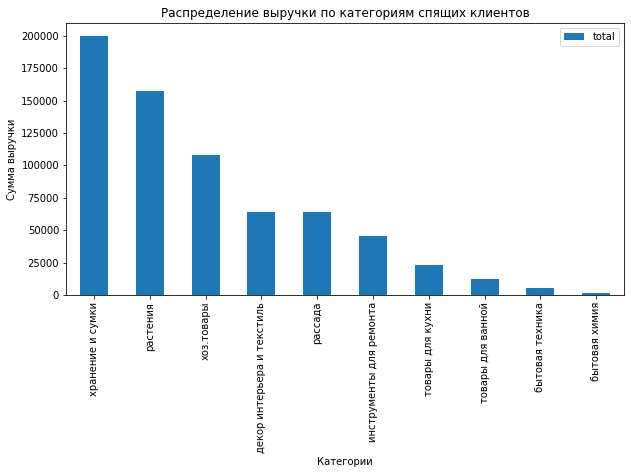

In [98]:
# визуализируем выручки по категориям спящих клиентов
sleeping.groupby('category').agg({'total':'sum'}).sort_values(by='total',ascending=False).plot(kind='bar',figsize=(10, 5))
plt.title('Распределение выручки по категориям спящих клиентов')
plt.ylabel('Сумма выручки')
plt.xlabel('Категории')
plt.show()

Самая большая выручка для спящих клиентов поступила от категории товаров хранения и сумок, выручка от бытовой техники и химии минимальна.

Посмотрим на сезонность.

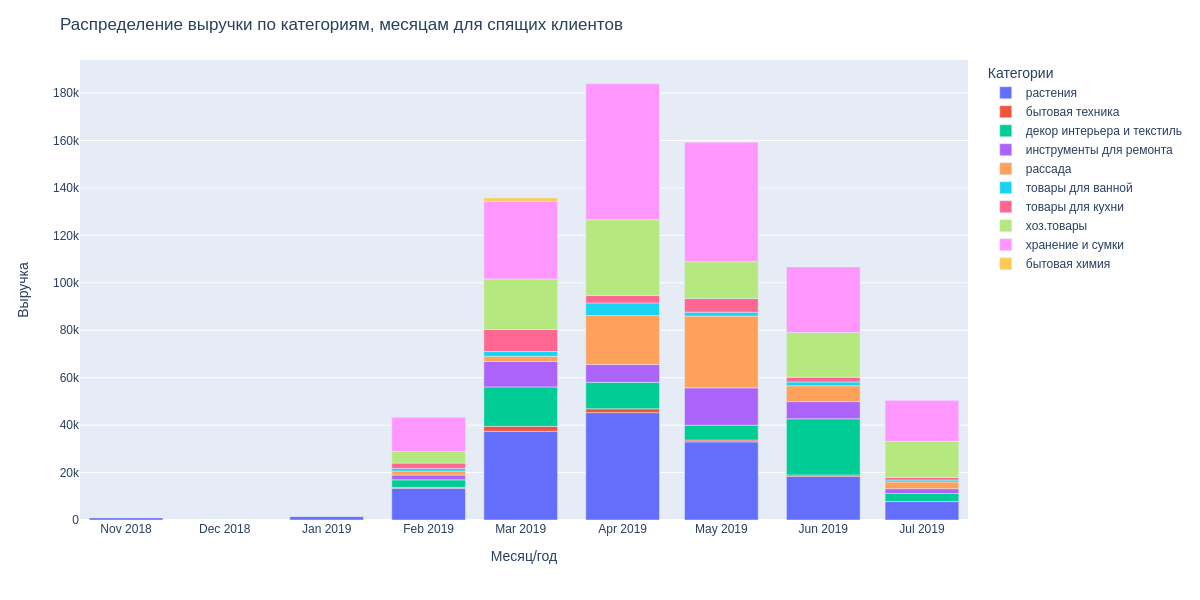

In [99]:
# распределение выручки по категориям и месяцам для спящих клиентов
fig = px.bar(sleeping_season, x="month", y="revenue", color = 'category')
fig.update_layout(title='Распределение выручки по категориям, месяцам для спящих клиентов',
                   xaxis_title='Месяц/год',
                   yaxis_title='Выручка',
                   yaxis={'categoryorder':'total ascending'},
                 legend=dict(title="Категории"))
fig.show(renderer='png',width=1200, height=600)

Выручка от клиентов преимущественно поступала с февраля по июль. Выручка от категорий хранения и сумок, растений, хоз.товаров, декора и текстиля, инструментов для ремонта увеличивается с февраля по май и уменьшается к июлю. Выручка на бытовую технику и товары для кухни максимальна в марте, на товары для ванны в апреле.

##### уходящие клиенты

In [100]:
# выделим уходящих клиентов
leaving = merge.loc[merge['segment_name'] == 'уходящие']

In [101]:
# выведем первые строки на экран
leaving.head(5)

,date,customer_id,order_id,product,quantity,price,month,year,total,category,recency,frequency,monetary_value,R_score,F_score,M_score,RFM_score,segment_name
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,2018-10-01,2018,142.0,растения,488,1,1037.0,1,1,3,113,уходящие
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,2018-10-01,2018,194.0,растения,488,1,1037.0,1,1,3,113,уходящие
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,2018-10-01,2018,112.0,растения,488,1,1037.0,1,1,3,113,уходящие
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,2018-10-01,2018,179.0,растения,488,1,1037.0,1,1,3,113,уходящие
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,2018-10-01,2018,112.0,растения,488,1,1037.0,1,1,3,113,уходящие


Сгруппируем данные перспективных клиентов по категориям товаров и месяцам покупок, посчитаем общую выручку, количество уникальных заказов, количество проданных товаров.

In [102]:
# сгруппируем таблицу
leaving_season = leaving.groupby(['month', 'category']).agg({'total':'sum','order_id':'nunique','product':'count'}).reset_index()

# переименуем столбцы для удобства
leaving_season.columns = ['month','category','revenue','order_amount','product_amount']

# добавим столбец со средней выручкой
leaving_season['average_bill'] = (leaving_season['revenue']/leaving_season['order_amount']).round()

# округлим значение выручки 
leaving_season['revenue'] = leaving_season['revenue'].round()

# выведем на экран
leaving_season.head(5)

,month,category,revenue,order_amount,product_amount,average_bill
0,2018-10-01,бытовая техника,6447.0,3,3,2149.0
1,2018-10-01,бытовая химия,2509.0,4,8,627.0
2,2018-10-01,декор интерьера и текстиль,25827.0,21,38,1230.0
3,2018-10-01,инструменты для ремонта,26899.0,10,11,2690.0
4,2018-10-01,рассада,2507.0,6,17,418.0


- выручка

Выведем сначала график выручки без учёта сезонности для того чтобы посмотреть как категории распределены между собой в целом.

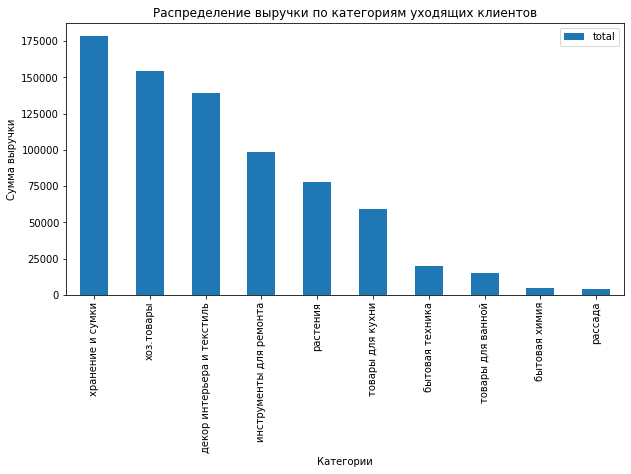

In [103]:
# визуализируем выручки по категориям уходящих клиентов
leaving.groupby('category').agg({'total':'sum'}).sort_values(by='total',ascending=False).plot(kind='bar',figsize=(10, 5))
plt.title('Распределение выручки по категориям уходящих клиентов')
plt.ylabel('Сумма выручки')
plt.xlabel('Категории')
plt.show()

Больше всего выручки принесли категории хранения и сумок, хз.товаров и декора и текстиля.

Посмотрим сезонность.

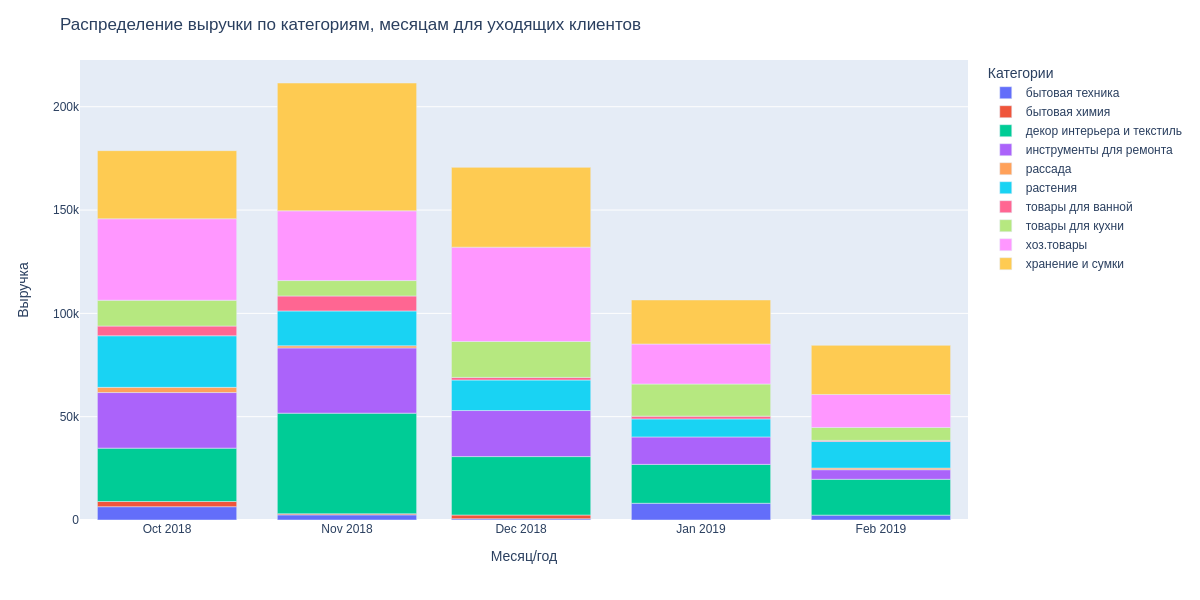

In [104]:
# распределение выручки по категориям и месяцам для уходящих клиентов
fig = px.bar(leaving_season, x="month", y="revenue", color = 'category')
fig.update_layout(title='Распределение выручки по категориям, месяцам для уходящих клиентов',
                   xaxis_title='Месяц/год',
                   yaxis_title='Выручка',
                   yaxis={'categoryorder':'total ascending'},
                 legend=dict(title="Категории"))
fig.show(renderer='png',width=1200, height=600)

 Для уходящих клиентов характерно:
    - в январе - бОльшая выручка на товары декора и текстиля, хранения и сумки, инструменты для ремонта, хоз.товары, товары для кухни и бытовую технику
    - в феврале - на растения и рассаду
    - в ноябре -декор интерьера и текстиль, инструменты для ремонта, хранения и сумок
    - в октябре - расстения и хоз.товары
    - в декабре - товары для кухни, хоз.товары

##### отток

In [105]:
# выделим отток клиентов
outflow = merge.loc[merge['segment_name'] == 'отток']

In [106]:
# выведем первые строки на экран
outflow.head(5)

,date,customer_id,order_id,product,quantity,price,month,year,total,category,recency,frequency,monetary_value,R_score,F_score,M_score,RFM_score,segment_name
21,2018-10-02 11:00:00,f08d9018-438e-4e96-b519-f74c0302a433,14480,многолетнее растение тимьян-чабрец розовый объ...,1,89.0,2018-10-01,2018,89.0,растения,487,1,359.0,1,1,1,111,отток
22,2018-10-02 11:00:00,f08d9018-438e-4e96-b519-f74c0302a433,14480,"рассада зелени для кухни базилик тонус, кассет...",1,169.0,2018-10-01,2018,169.0,рассада,487,1,359.0,1,1,1,111,отток
23,2018-10-02 11:00:00,f08d9018-438e-4e96-b519-f74c0302a433,14480,рассада зелени для кухни мелиссы в горшке диам...,1,101.0,2018-10-01,2018,101.0,рассада,487,1,359.0,1,1,1,111,отток
24,2018-10-02 13:00:00,32a85453-f14d-40c2-90ba-3851498a5f3b,68460,сумка для тележки большая комбинированная 45*3...,1,374.0,2018-10-01,2018,374.0,хранение и сумки,487,1,374.0,1,1,1,111,отток
36,2018-10-02 18:00:00,5f75c73a-1305-4079-b040-2bcb42085002,68509,сушилка для белья настенная zalger prima 510-7...,1,299.0,2018-10-01,2018,299.0,хоз.товары,486,1,299.0,1,1,1,111,отток


Сгруппируем данные перспективных клиентов по категориям товаров и месяцам покупок, посчитаем общую выручку, количество уникальных заказов, количество проданных товаров.

In [107]:
# сгруппируем таблицу
outflow_season = outflow.groupby(['month', 'category']).agg({'total':'sum','order_id':'nunique','product':'count'}).reset_index()

# переименуем столбцы для удобства
outflow_season.columns = ['month','category','revenue','order_amount','product_amount']

# добавим столбец со средней выручкой
outflow_season['average_bill'] = (outflow_season['revenue']/outflow_season['order_amount']).round()

# округлим значение выручки 
outflow_season['revenue'] = outflow_season['revenue'].round()

# выведем на экран
outflow_season.head(5)

,month,category,revenue,order_amount,product_amount,average_bill
0,2018-10-01,декор интерьера и текстиль,692.0,3,3,231.0
1,2018-10-01,инструменты для ремонта,1066.0,5,8,213.0
2,2018-10-01,рассада,270.0,1,2,270.0
3,2018-10-01,растения,1521.0,7,10,217.0
4,2018-10-01,товары для ванной,882.0,4,4,220.0


- выручка

Выведем сначала график выручки без учёта сезонности для того чтобы посмотреть как категории распределены между собой в целом.

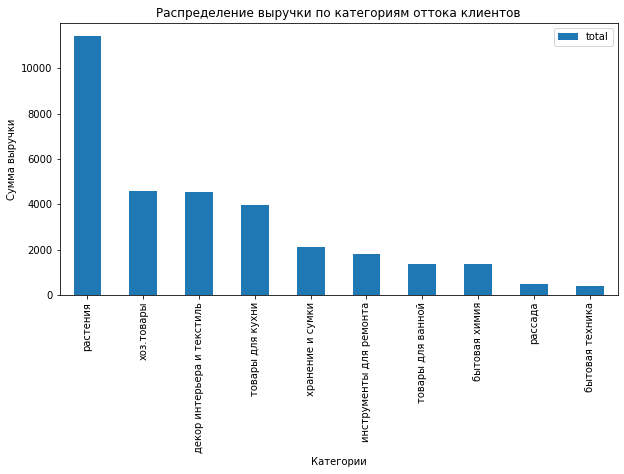

In [108]:
# визуализируем выручки по категориям оттока клиентов
outflow.groupby('category').agg({'total':'sum'}).sort_values(by='total',ascending=False).plot(kind='bar',figsize=(10, 5))
plt.title('Распределение выручки по категориям оттока клиентов')
plt.ylabel('Сумма выручки')
plt.xlabel('Категории')
plt.show()

Клиенты оттока больше всего заказывали товаров категории растений.

Посмотрим на сезонность.

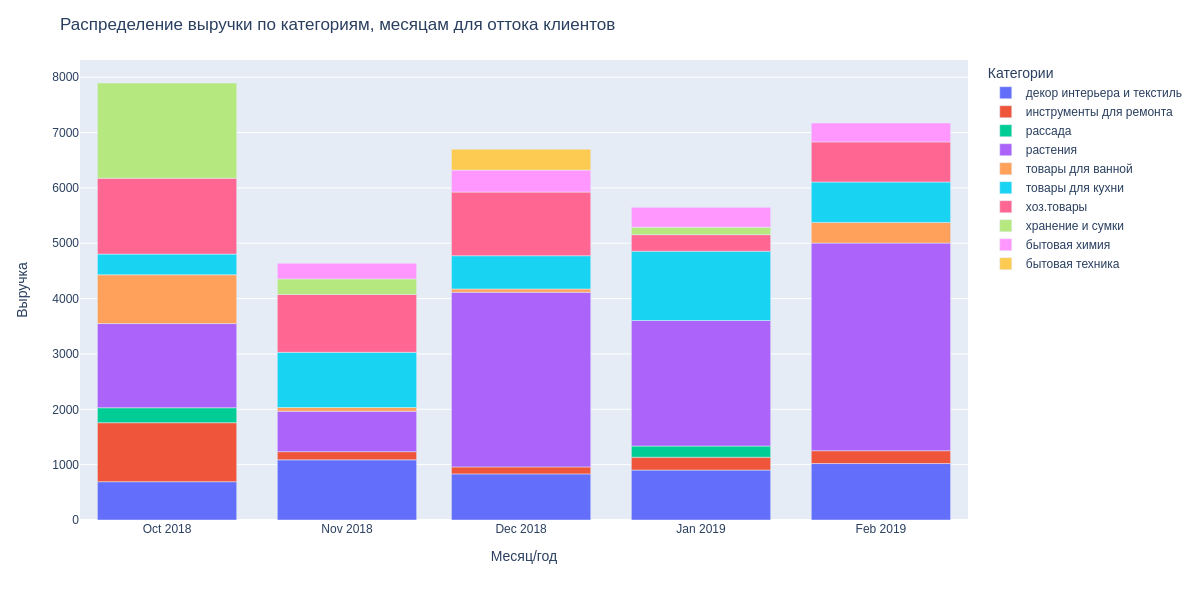

In [109]:
# распределение выручки по категориям и месяцам для оттока клиентов
fig = px.bar(outflow_season, x="month", y="revenue", color = 'category')
fig.update_layout(title='Распределение выручки по категориям, месяцам для оттока клиентов',
                   xaxis_title='Месяц/год',
                   yaxis_title='Выручка',
                   yaxis={'categoryorder':'total ascending'},
                 legend=dict(title="Категории"))
fig.show(renderer='png',width=1200, height=600)

Для клиентов оттока характерно:
    - в январе - бОльшая выручка на товары для хранения и сумки, товары для кухни, инструменты для дома
    - в феврале - на товары категории растений, хоз.товары и товары для ванной
    - в декабре - растения, бытовая техника и хоз.товары
    - в ноябре - декор и текстиль интерьера, овары для кухни, хранение и сумки
    - в октябре - хранение и сумки, бытовая техника, рассада и нструменты для ремонта

### Проверка гипотез

Для проверки корректности разбиения клиентов на сегменты, проверим статистические гипотезы и выясним, есть ли статистическая значимая разница между сегментами.

Для удобства используем таблицу подготовленную для сегментации сгруппированной по клиентам.

In [110]:
# зададим из подготовленных ранее данных, удалив некоторые столбцы для удобства
segment_table = RFM_segment.drop(columns=['R_score','F_score','M_score','RFM_score'])

# переименуем столбец для удобства
segment_table.rename(columns={'monetary_value':'revenue'}, inplace=True)

# выведем первые 5 строк
segment_table.head(5)

,recency,frequency,revenue,segment_name
customer_id,,,,
000d6849-084e-4d9f-ac03-37174eaf60c4,108,1,555.0,перспективные
001cee7f-0b29-4716-b202-0042213ab038,350,1,442.0,уходящие
00299f34-5385-4d13-9aea-c80b81658e1b,109,1,914.0,перспективные
002d4d3a-4a59-406b-86ec-c3314357e498,369,1,1649.0,уходящие
003bbd39-0000-41ff-b7f9-2ddaec152037,124,1,2324.0,перспективные


В датафрейме 2451 строк, отражающих поведение уникальных пользователей магазина по : давности покупок, частоте, общей прибыли и название сегмента.

#### гипотеза о выручке

Сформулируем нулевую и альтернативную гипотезы:

 - Н0: Между сегментами нет стат.значимой разницы в выручке
 - Н1: Между сегментами есть стат.значимая разница в выручке

Для проверки гипотез применим непараметрический тест Уилкоксона-Манна-Уитни.\
Так как у нас идет множественная проверка гипотез, дабы снизить вероятности допустить ошибку первого рода, критический уровень статистической значимости скорректируем с учетом поправки Шидака.

In [111]:
# напишем функцию для проверки сегментов по непараметрический тесту Уилкоксона-Манна-Уитни
def check_segment_revenue(segment_1, segment_2):
    results = st.mannwhitneyu(segment_table[segment_table['segment_name']==segment_1]['revenue'],
                              segment_table[segment_table['segment_name']==segment_2]['revenue'])
    # критический уровень статистической значимости
    alpha = 0.005
    
    # число проводимых сравнений
    m = 10
    
    # считаем поправку
    alpha_sidak = 1 - (1 - alpha) ** (1/m)
    
    print('p-значение: ', results.pvalue)
    if results.pvalue < alpha_sidak:
        print(f'Отвергаем нулевую гипотезу: разница между сегментами {segment_1} и {segment_2} статистически значима')
    else:
        print(f'Не получилось отвергнуть нулевую гипотезу, вывод о различии между сегментами {segment_1} и {segment_2} сделать нельзя')
    print()
    

In [112]:
check_segment_revenue('лояльные', 'перспективные')
check_segment_revenue('лояльные', 'спящие')
check_segment_revenue('лояльные', 'уходящие')
check_segment_revenue('лояльные', 'отток')

p-значение:  1.1759485790350345e-08
Отвергаем нулевую гипотезу: разница между сегментами лояльные и перспективные статистически значима

p-значение:  1.2575668855524865e-12
Отвергаем нулевую гипотезу: разница между сегментами лояльные и спящие статистически значима

p-значение:  0.08587378251785391
Не получилось отвергнуть нулевую гипотезу, вывод о различии между сегментами лояльные и уходящие сделать нельзя

p-значение:  1.5570665731717069e-55
Отвергаем нулевую гипотезу: разница между сегментами лояльные и отток статистически значима



In [113]:
check_segment_revenue('перспективные', 'спящие')
check_segment_revenue('перспективные', 'уходящие')
check_segment_revenue('перспективные', 'отток')

p-значение:  0.2870240610716335
Не получилось отвергнуть нулевую гипотезу, вывод о различии между сегментами перспективные и спящие сделать нельзя

p-значение:  4.0813923034957247e-14
Отвергаем нулевую гипотезу: разница между сегментами перспективные и уходящие статистически значима

p-значение:  6.052730184265325e-37
Отвергаем нулевую гипотезу: разница между сегментами перспективные и отток статистически значима



In [114]:
check_segment_revenue('спящие', 'уходящие')
check_segment_revenue('спящие', 'отток')

p-значение:  4.630527718850257e-20
Отвергаем нулевую гипотезу: разница между сегментами спящие и уходящие статистически значима

p-значение:  9.387239701424256e-39
Отвергаем нулевую гипотезу: разница между сегментами спящие и отток статистически значима



In [115]:
check_segment_revenue('уходящие', 'отток')

p-значение:  1.217326696628001e-72
Отвергаем нулевую гипотезу: разница между сегментами уходящие и отток статистически значима



Все сегменты, кроме лояльные-уходящие и перспективные-спящие, показали статистическую разницу в выручке между собой.\
Проверим статистическую значимость давности покупки между сегментами.

#### гипотеза о давности

Сформулируем нулевую и альтернативную гипотезы:

 - Н0: Между сегментами нет стат.значимой разницы в давности покупок
 - Н1: Между сегментами есть стат.значимая разница в давности покупок

In [116]:
# напишем функцию для проверки сегментов по непараметрический тесту Уилкоксона-Манна-Уитни
def check_segment_recency(segment_1, segment_2):
    results = st.mannwhitneyu(segment_table[segment_table['segment_name']==segment_1]['recency'],
                              segment_table[segment_table['segment_name']==segment_2]['recency'])
    
    # критический уровень статистической значимости
    alpha = 0.005
    
    # число проводимых сравнений
    m = 10
    
    # считаем поправку
    alpha_sidak = 1 - (1 - alpha) ** (1/m)
    
    print('p-значение: ', results.pvalue)
    if results.pvalue < alpha_sidak:
        print(f'Отвергаем нулевую гипотезу: разница между сегментами {segment_1} и {segment_2} статистически значима')
    else:
        print(f'Не получилось отвергнуть нулевую гипотезу, вывод о различии между сегментами {segment_1} и {segment_2} сделать нельзя')
    print()
    

In [117]:
check_segment_recency('лояльные', 'перспективные')
check_segment_recency('лояльные', 'спящие')
check_segment_recency('лояльные', 'уходящие')
check_segment_recency('лояльные', 'отток')

p-значение:  4.0248387222887664e-195
Отвергаем нулевую гипотезу: разница между сегментами лояльные и перспективные статистически значима

p-значение:  6.003804242597241e-196
Отвергаем нулевую гипотезу: разница между сегментами лояльные и спящие статистически значима

p-значение:  1.1030115115643062e-167
Отвергаем нулевую гипотезу: разница между сегментами лояльные и уходящие статистически значима

p-значение:  2.6806710257943932e-79
Отвергаем нулевую гипотезу: разница между сегментами лояльные и отток статистически значима



In [118]:
check_segment_recency('перспективные', 'спящие')
check_segment_recency('перспективные', 'уходящие')
check_segment_recency('перспективные', 'отток')

p-значение:  3.7788212994358885e-194
Отвергаем нулевую гипотезу: разница между сегментами перспективные и спящие статистически значима

p-значение:  2.300241318992295e-166
Отвергаем нулевую гипотезу: разница между сегментами перспективные и уходящие статистически значима

p-значение:  5.3415350966073e-79
Отвергаем нулевую гипотезу: разница между сегментами перспективные и отток статистически значима



In [119]:
check_segment_recency('спящие', 'уходящие')
check_segment_recency('спящие', 'отток')

p-значение:  5.799766456548906e-167
Отвергаем нулевую гипотезу: разница между сегментами спящие и уходящие статистически значима

p-значение:  3.949074861984791e-79
Отвергаем нулевую гипотезу: разница между сегментами спящие и отток статистически значима



In [120]:
check_segment_recency('уходящие', 'отток')

p-значение:  0.013675340576385656
Не получилось отвергнуть нулевую гипотезу, вывод о различии между сегментами уходящие и отток сделать нельзя



Все сегменты, кроме уходящие-отток показали между собой статистическую значимость в давности покупок между сегментами.

Если хотя бы одна из двух проверок показала статистическую значимость - значит разбиение на сегменты корретно.

Таким образом, делаем вывод, что разбиение на сегменты проведено корректно.

### Презентация

Презентация: <https://disk.yandex.ru/i/dB-u2qkBEG3KnA>

### Общий вывод

В результате проведенного анализа данных о покупках клиентов с 1 октября 2018 по 31 января 2020 года интернет-магазина товаров для дома и быта «Пока все ещё тут» было выявлено:

**Количество клиентов**
- 2413 уникальный клиент интернет-магазина
- рост количества клиентов в конце 2019 года

**Выручка**
- общая выручка составила 4 601 279.4 руб
- самая высокая выручка была зафиксирована в июне 2019 года- 900 тыс.руб
- минимум приходится на ноябрь 2019 года - 130 тыс.руб
- в остальном выручка колеблется в пределах 200-350 тыс.руб

**Средняя стоимость заказа**
- средняя стоимость заказа 1000 руб
- самый высокий чек зафиксирован в июне 2019 года - 5.5 тыс.руб
- самый низкий - ноябрь 2019 (594 руб)

**Частота заказов**
- большинство клиентов - 1534 человек, совершают в интернет-магазине заказ лишь единажды. Практически в 2 раза меньше клиентов, которые совершают 2 заказа (842 человека) и совсем небольшое количество пользователей с 3 заказми (20 человек) и более

**Количество товаров в заказе**
- большинство заказов - 2892, содержат лишь 1 товар,  100 заказов с 2 товарами, 3 товара - 66 заказов

**Количество заказов**
- Меньше всего заказов в июне 2019года - 163
- больше всего заказов зафиксировано в феврале 2019 года - 289

На основе историй покупок клиентов применили RFM-анализ и разделили покупателей на сегменты:
- лояльные (те, кто много, часто и дорого покупает)
- перспективные
- спящие
- уходящие
- отток (те, кто покупал давно, редко и на небольшую сумму)

Анализ учитывает давность совершения покупки(сколько дней прошло с момента последней покупки), частоту покупок (сколько раз клиент совершал покупку в данном интернет-магазине) и денежную ценность (сумму денег), которую принес покупатель бизнесу.

Также были сформированы категории покупок исходя из наименования товара:
- растения                      1586
- хоз.товары                     619
- хранение и сумки               603
- рассада                        563
- декор интерьера и текстиль     467
- товары для кухни               270
- инструменты дял ремонта        209
- товары для ванной              110
- бытовая техника                 83
- бытовая химия                   53

Чаще всего клиенты растения - 1586 покупок, реже - бытовая химия - 53 покупки.

Выявили сезонность и проанализировали данные исходя из сформированных сегментов и категорий проодаваемых товаров, исходя из которых можно сделать следующие рекомендации:

**Рекомендации**


- лояльные клиенты (покупают много, часто и дорого):
    
 Это те клиенты, которые наиболее лояльны бизнесу, можно попыться повысить чек, количество покупок за счёт персонализирвоанных предложений, дабы удержать костяк.Можно сообщать о запуске нового товара.
 
 Для лояльных клиентов характерно увеличение выручки, категорий :
     - в январе - товары для декора текстиля и инструменты для ремонта, рассада
     - в декабре - товаров для хранения и сумки, хоз.товаров, декора и текстиля, инструменты для ремонта, товаров для кухни, а также товарами из категорий растений
     - в марте - хранения и сумки, хоз.товаров
     - в феврале -  категорию хоз.товаров и товаров для кухни
     - в ноябре - бытовой техникой хорошо закупаются в ноябре
     - в апреле -  рассада
 
 Октябрь - низкий сезон.


- перспективные клиенты:
    
 Новые и регулярные потребители, которые часто заказывают на средний чек. Можно попытаться пренести их в лояльный класс путем различных коммуникаций.
 
 Клиенты данного сегмента практически не попали в покупки первой половины года, активные покупки демонстрируют с июля по ноябрь Прослеживается увеличение выручки практически по всем категориям с августа по октябрь и уменьшение к декабрю. 
 
 Для перспективных клиентов характерно увеличение выручки, категорий :
    - в августе - товаров для хранения и сумок, бытовой химии
    - в октябре - хранения и сумок, хоз.товаров, растения и товаров для интерьера и текстиля
    - в июле - растения и товаров для интерьера и текстиля, товары для кухни
    - в сентябре - товары для кухни
 
 Выручка по категории инструментов для ремонта увеличивается с июля достигая пика в октябре.
    
    
- спящие клиенты:
    
 Потребители, которые раньше часто покупали на разные чеки, но перестали со временем. Поробовать реактивировать их.
 
 Для спящих клиентов характерно увеличение выручки на категории:
    - с февраля по май - категории хранения и сумок, растений, хоз.товаров, декора и текстиля, инструментов для ремонта 
    - в марте - на бытовую технику и товары для кухни
    - в апреле - товары для ванной
    
    
- уходящие клиенты:

 Клиенты, которые покупали давно, но совершили больше одной покупки или на среднюю сумму. Можно попробовать сократить отток и использовать скидки на повторные заказы, программы лояльности, другие выгодные предложения.
 
 Для уходящих клиентов характерно:
    - в январе - бОльшая выручка на товары декора и текстиля, хранения и сумки, инструменты для ремонта, хоз.товары, товары для кухни и бытовую технику
    - в феврале - на растения и рассаду
    - в ноябре -декор интерьера и текстиль, инструменты для ремонта, хранения и сумок
    - в октябре - расстения и хоз.товары
    - в декабре - товары для кухни, хоз.товары
    
    
- отток:

 Это те клиенты, которые покупали давно, мало и на небольшую сумму.
 
 Для клиентов оттока характерно:
    - в январе - бОльшая выручка на товары для хранения и сумки, товары для кухни, инструменты для дома
    - в феврале - на товары категории растений, хоз.товары и товары для ванной
    - в декабре - растения, бытовая техника и хоз.товары
    - в ноябре - декор и текстиль интерьера, овары для кухни, хранение и сумки
    - в октябре - хранение и сумки, бытовая техника, рассада и нструменты для ремонта
    
 Скорее всего вернуть их уже не получится, поэтому лучше не тратить на них бюджет.